In [ ]:
#code by Duc Huy Nguyen
#ref: 
# https://github.com/y-kawagu/dcase2020_task2_baseline/tree/ebfcc2ae886511d074a4e746890c3ef877800de0
# https://github.com/AlexandrineRibeiro/DCASE-2020-Task-2

In [ ]:
!pip install pqdm
import csv
import glob
import multiprocessing
import os

import sys
from functools import partial
from venv import logger
import re
import itertools

import librosa
import librosa.core
import librosa.feature

import numpy
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, auc
import keras.models
from keras.layers import Input, Dense, BatchNormalization
from keras.models import Model
from tqdm import tqdm
import tensorflow as tf
import tqdm
from pqdm.processes import pqdm
import matplotlib.pyplot as plt  

In [ ]:

def file_load(wav_name, mono=False):
    """
    load .wav file.
    wav_name : str
        target .wav file
    sampling_rate : int
        audio file sampling_rate
    mono : boolean
        When load a multi channels file and this param True, the returned data will be merged for mono data
    return : numpy.array( float )
    """
    try:
        return librosa.load(wav_name, sr=None, mono=mono)
    except:
        logger.error("file_broken or not exists!! : {}".format(wav_name))
# feature extractor
def raw_feature_extractor(audio_path):
  data=file_load(audio_path)
  frequency = data[1]
  totalLength=len(data[0])
  sounddata=data[0]*1000
  newvector = []
  for i in range(int(totalLength/160)):
      frame = numpy.asarray(sounddata[160*i:160*(i+1)])
      #frame = numpy.asarray(frame)
      newvector.append(frame)

  return numpy.asarray(newvector)
  
def file_to_array(train_files):
    #par_file = partial(MFEC_extractor)
    par_file = partial(Raw_feature_extractor)
    files = pqdm(train_files, par_file, n_jobs=multiprocessing.cpu_count())
    files_list = []
    for i in files:
        files_list.append(i)
    array = numpy.asarray(files_list)
    array = array.reshape(array.shape[1] * len(files), array.shape[2])
    return array


def get_model(inputDim, name_for_model=""):
    """
    define the keras model
    the model based on the simple dense auto encoder
    (128*128*128*8*128*128*128)
    """
    inputLayer = Input(shape=(inputDim,))

    h = Dense(128)(inputLayer)  
    h = BatchNormalization()(h)
    h = keras.layers.ReLU()(h)

    #h = Dense(512)(h)
    #h = BatchNormalization()(h)
    #h = keras.layers.ReLU()(h)

    h = Dense(128)(h)
    h = BatchNormalization()(h)
    h = keras.layers.ReLU()(h)

    h = Dense(128)(h)
    h = BatchNormalization()(h)
    h = keras.layers.ReLU()(h)

    h = Dense(8)(h)
    h = BatchNormalization()(h)
    h = keras.layers.ReLU()(h)

    #h = Dense(512)(h)
    #h = BatchNormalization()(h)
    #h = keras.layers.ReLU()(h)

    h = Dense(128)(h)
    h = BatchNormalization()(h)
    h = keras.layers.ReLU()(h)

    h = Dense(128)(h)
    h = BatchNormalization()(h)
    h = keras.layers.ReLU()(h)

    h = Dense(128)(h)
    h = BatchNormalization()(h)
    h = keras.layers.ReLU()(h)

    h = Dense(inputDim)(h)

    AutoEncoder = Model(inputLayer, h, name='AE' + name_for_model)
    AutoEncoder.compile(optimizer='adam', loss="mse")
    return AutoEncoder
def eval_model_stream(target_dir, model, machine_type):
    from tqdm import tqdm
    test_dir = target_dir+'/test'
    files = os.listdir(test_dir)[0]

    id = re.findall('id_[0-9][0-9]',files) 

    test_files, y_true = test_file_list_generator(target_dir, id)

    print("\n============== BEGIN TEST ==================")
    MSE_score = [0. for k in test_files]
    for id, file_path in tqdm(enumerate(test_files), total=len(test_files)):
        #data = file_to_vector_array_stream_test_data(file_path)
        data = raw_feature_extractor(file_path)
        reconstruction_loss = (data - model.predict(data))
        errors_arr = numpy.mean(numpy.square(reconstruction_loss), axis=1)
        MSE_score[id] = numpy.mean(errors_arr)
        

        #Draw AUC/pAUC table
    fpr, tpr, threshold = roc_curve(y_true, MSE_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='AUC = ' + str(round(roc_auc, 2)))
    plt.legend(loc='lower right')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


    #Extract fpr and threshold
    Auc = roc_auc_score(y_true, MSE_score)
    p_auc = roc_auc_score(y_true, MSE_score, max_fpr=0.1)
    print("AUC : {}".format(Auc))
    print("pAUC : {}".format(p_auc))

    print("\n============ END TEST ============")

    return  fpr, tpr, threshold




def test_file_list_generator(target_dir, id_name, dir_name="test",
                             prefix_normal="normal", prefix_anomaly="anomaly",
                             ext="wav"):
    normal_files = sorted(
        glob.glob("{dir}/{dir_name}/{prefix_normal}_{id_name}*.{ext}"
                  .format(dir=target_dir, dir_name=dir_name,
                          prefix_normal=prefix_normal,
                          id_name=id_name, ext=ext)))

    normal_labels = numpy.zeros(len(normal_files))
    anomaly_files = sorted(
        glob.glob("{dir}/{dir_name}/{prefix_anomaly}_{id_name}*.{ext}"
                  .format(dir=target_dir, dir_name=dir_name,
                          prefix_anomaly=prefix_anomaly,
                          id_name=id_name, ext=ext)))

    anomaly_labels = numpy.ones(len(anomaly_files))
    files = numpy.concatenate((normal_files, anomaly_files), axis=0)
    labels = numpy.concatenate((normal_labels, anomaly_labels), axis=0)

    if len(files) == 0:
        print("no_wav_file!!")

    return files, labels


SUBMITTING | :   0%|          | 0/334 [00:00<?, ?it/s]

Processing fan


SUBMITTING | : 100%|██████████| 334/334 [00:00<00:00, 2551.43it/s]
PROCESSING | : 100%|██████████| 334/334 [00:01<00:00, 169.95it/s]
COLLECTING | : 100%|██████████| 334/334 [00:00<00:00, 94937.49it/s]


Epoch 1/50
914/914 [==============================] - 15s 13ms/step - loss: 46.7262 - val_loss: 61.3324

Epoch 00001: val_loss improved from inf to 61.33236, saving model to /content/drive/MyDrive/luanvan/dulieu/fan/bestModel_fan.H5
INFO:tensorflow:Assets written to: /content/drive/MyDrive/luanvan/dulieu/fan/bestModel_fan.H5/assets
Epoch 2/50
914/914 [==============================] - 12s 13ms/step - loss: 36.0552 - val_loss: 60.2150

Epoch 00002: val_loss improved from 61.33236 to 60.21500, saving model to /content/drive/MyDrive/luanvan/dulieu/fan/bestModel_fan.H5
INFO:tensorflow:Assets written to: /content/drive/MyDrive/luanvan/dulieu/fan/bestModel_fan.H5/assets
Epoch 3/50
914/914 [==============================] - 12s 13ms/step - loss: 35.2054 - val_loss: 55.6515

Epoch 00003: val_loss improved from 60.21500 to 55.65149, saving model to /content/drive/MyDrive/luanvan/dulieu/fan/bestModel_fan.H5
INFO:tensorflow:Assets written to: /content/drive/MyDrive/luanvan/dulieu/fan/bestModel_fa

  0%|          | 0/129 [00:00<?, ?it/s]


============== BEGIN TEST FOR ID ==============


100%|██████████| 129/129 [00:13<00:00,  9.46it/s]


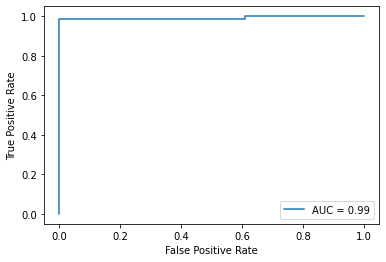

AUC : 0.990625
pAUC : 0.9919028340080972

============ END OF TEST FOR A MACHINE ID ============
fpr:  [0.       0.       0.       0.015625 0.078125 0.15625  0.25     0.265625
 0.484375 0.515625 0.609375 0.609375 1.      ]
threshold:  [3986.2415   3985.2415     61.31106    58.676804   57.81195    56.429047
   56.300148   56.13894    55.439667   55.2579     53.8557     45.715477
   12.925196]


In [ ]:
if __name__ == '__main__':
    path = "/content/drive/MyDrive/luanvan/dulieu/"
    os.chdir(path)
    folders = ["fan"]
    #folders = ["fan0","fan2"]
    

    for f in folders:
        callbacks_listv1 = [
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                mode='min',
                patience=5,
                min_delta=0.01,
                restore_best_weights=True,

            ), keras.callbacks.ModelCheckpoint(
                monitor='val_loss',
                mode='min',
                filepath=path+ f + "/bestModel" + "_" + f + ".H5",
                save_best_only=True,
                verbose=1
            )]
        files_Read = []
        print("Processing", f)

        for file in glob.glob(f+"/train/*.wav"):
            files_Read.append(file)
        input = file_to_array(files_Read)  
        AutoEncoder = get_model(inputDim=input.shape[1], name_for_model=f)
        AutoEncoder.fit(input, input, batch_size=256, epochs=50, callbacks=callbacks_listv1, validation_split=0.3)
        AEBest = keras.models.load_model(path+f+"/bestModel" + "_" + f + ".H5")
        fpr, tpr, threshold = eval_model_stream(path+ f , AEBest, f)
        print("fpr: ", fpr)
        print("threshold: ", threshold)


In [ ]:
fpr_accept = 0.1
for i in range(len(fpr)):
  if fpr[i]> fpr_accept:
    _ = i-1
    break
print("with fp rate = ",fpr_accept ,"threshold =", threshold[_])

with fp rate =  0.1 threshold = 93.551315


In [ ]:
import tensorflow as tf

# Convert the model
#converter = tf.lite.TFLiteConverter.from_saved_model("/content/drive/MyDrive/luanvan/data/bestModel_fan.H5") # path to the SavedModel directory
converter = tf.lite.TFLiteConverter.from_keras_model(AEBest)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpja7deqjs/assets


In [ ]:
path = os.getcwd()
path
os.chdir("/content/drive/MyDrive/luanvan/dulieu/tflite")
# Save the model.
open('model.tflite', 'wb').write(tflite_model)

116992

In [ ]:
AEBest = keras.models.load_model("/content/drive/MyDrive/luanvan/dulieu/fan"+"/bestModel" + "_" + f + ".H5")
AEBest.summary()

Model: "AEfan"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160)]             0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               20608     
_________________________________________________________________
batch_normalization_18 (Batc (None, 128)               512       
_________________________________________________________________
re_lu_18 (ReLU)              (None, 128)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_19 (Batc (None, 128)               512       
_________________________________________________________________
re_lu_19 (ReLU)              (None, 128)               0     